In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import math



p = os.path.abspath('../') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

# data 분류

In [3]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('../../voice_data/fusion/pathology/phrase/*.wav')
healthy = glob('../../voice_data/fusion/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))


pathology= [ path.split("\\")[-1] for path in pathology] # path 데이터 변환.
healthy= [ path.split("\\")[-1] for path in healthy] # path 데이터 변환.
 # path 데이터 변환


X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<1193:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  1193
Healthy:  634
총 데이터수 :  1827
---
훈련 셋 :  1461 Counter({'pathology': 954, 'healthy': 507})
테스트 셋 :  366 Counter({'pathology': 239, 'healthy': 127})
---


In [4]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 763}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 191} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 763}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 191} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 763}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 191} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 763}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 191} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 190} 



In [5]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res




 fold0 
before dataset shape Counter({'pathology': 763, 'healthy': 405})
Resampled dataset shape Counter({'pathology': 763, 'healthy': 763})

 fold1 
before dataset shape Counter({'pathology': 763, 'healthy': 406})
Resampled dataset shape Counter({'pathology': 763, 'healthy': 763})

 fold2 
before dataset shape Counter({'pathology': 763, 'healthy': 406})
Resampled dataset shape Counter({'pathology': 763, 'healthy': 763})

 fold3 
before dataset shape Counter({'pathology': 763, 'healthy': 406})
Resampled dataset shape Counter({'pathology': 763, 'healthy': 763})

 fold4 
before dataset shape Counter({'pathology': 764, 'healthy': 405})
Resampled dataset shape Counter({'pathology': 764, 'healthy': 764})


In [6]:
import pickle

 
#load
with open("../../voice_data/fusion/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

    

# data set

In [7]:
phrase_dict['101-phrase.wav'].size

49687

In [8]:
from torch.utils.data import Dataset, DataLoader

classes = ["pathology","healthy"]
sr=16000
win_length =  np.int64(sr/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, signal 변환
        2. raw 데이터 바로 출력.
        
        """

        sig = phrase_dict[self.path_list[idx]]
        sig_length = sig.size #sig length 리턴에 사용. feature 추출및 학습에 사용.
        pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
        length = 101951
        sig=pad1d(sig,length)
        sig=torch.from_numpy(sig).type(torch.float32)# 타입 변화
        
        return sig, self.classes.index(self.label[idx]), sig_length

In [9]:
# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes

        
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, signal 변환
        2. raw 데이터 바로 출력.
        
        """

        sig = phrase_dict[self.path_list[idx]]
        sig_length = sig.size #sig length 리턴에 사용. feature 추출및 학습에 사용.
        pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))
        length = 101951
        sig=pad1d(sig,length)
        sig=torch.from_numpy(sig).type(torch.float32)# 타입 변화
        
        return sig, self.classes.index(self.label[idx]), sig_length

# data loader

In [10]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 50 # 전체 데이터 셋을 50번 반복

In [11]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인



train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                                   classes,
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



In [12]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 

# model

https://pytorch.org/audio/main/tutorials/speech_recognition_pipeline_tutorial.html


dat1=torch.randn((32,12,318,768))
model1=nn.Conv2d(12,3,(3,3))
dat2=model1(dat1)
print(dat2.size())
#torch.Size([32, 3, 316, 766])
res_18_sample = models.resnet18(pretrained=True)
dat3=res_18_sample(dat2)
print(dat3.size())



In [123]:
for x_train,label,sig_size in train_loader:
    print(label,sig_size)
    break

bundle = torchaudio.pipelines.WAV2VEC2_LARGE_LV60K
model_wav2vec = bundle.get_model().to(DEVICE)
with torch.inference_mode():
    x,_ = model_wav2vec.extract_features(x_train.cuda())
    
x[0].size()

tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 1])


torch.Size([32, 318, 1024])

In [124]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [125]:
len(x)

24

In [126]:
x[3].mean(axis=1).size()

torch.Size([32, 1024])

In [127]:
x=[ feat.mean(axis=1) for feat  in  x]
print(x[0].size())

torch.Size([32, 1024])


In [128]:
x_st=torch.stack(x,dim=1)

In [129]:
x_st.size()

torch.Size([32, 24, 1024])

In [130]:
x_st[0]

tensor([[ 1.2689e+00,  4.5372e+00,  4.7224e+00,  ..., -3.1881e+00,
         -1.2508e+00,  4.2440e+00],
        [ 2.6962e+00,  1.8274e+00,  2.7861e+00,  ..., -1.6100e+00,
          2.6430e+00,  3.1690e+00],
        [-7.9697e-01,  4.9229e-01,  1.5447e+00,  ..., -7.2791e-01,
          4.8689e+00,  3.1841e+00],
        ...,
        [ 4.8385e+02, -2.7319e+02,  1.4658e+03,  ...,  3.9480e+02,
         -8.5345e+01,  4.1473e+02],
        [-3.1151e+02, -3.3251e+02, -8.2217e+02,  ..., -1.5148e+03,
          9.1420e+01,  2.2471e+02],
        [-3.0403e+02, -3.5513e+02, -8.1731e+02,  ..., -1.5722e+03,
          1.0110e+02,  2.2818e+02]], device='cuda:0')

In [131]:
x_st=x_st.cpu().numpy()



In [132]:
x_pd=[pd.DataFrame(dat.T) for dat in x_st]

In [149]:
x_pd[3]

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.675009,3.204393,-0.575100,3.660872,1.537907,2.153218,3.231173,3.073558,2.747115,2.747215,...,5.405088,9.538293,10.747893,13.735523,13.370246,27.447100,15.051143,493.128815,-304.935516,-297.948181
1,3.084132,0.755658,-0.935046,-1.357580,-1.884770,0.312395,0.739119,0.873886,4.249029,4.215664,...,2.006652,3.347179,-4.900560,-7.876776,1.711012,-9.310768,-4.733806,-283.306213,-345.058411,-367.575073
2,4.032837,1.935366,1.195742,1.503590,1.726250,1.493957,0.062888,-1.254647,-0.619291,-0.200998,...,4.399410,0.844560,0.807187,1.594805,15.267712,15.108256,5.596946,1502.604736,-791.456421,-786.229553
3,2.890185,0.778603,3.153392,1.909130,2.614849,5.209439,5.773824,8.103090,10.158640,9.139538,...,13.533770,10.045040,7.658255,17.996838,19.869410,22.350849,20.987875,-496.748596,1112.368164,1113.618896
4,-0.549156,-1.313958,0.264355,-2.537083,-1.891311,-0.064238,1.705711,3.620476,3.578080,5.081014,...,-0.973672,-2.910604,-1.849994,2.856737,3.652284,2.083322,-5.458484,-192.074692,-2876.759521,-2847.813232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,6.262953,7.912031,6.333463,5.309113,6.467828,5.701720,4.884234,8.213510,8.180402,3.817641,...,12.685925,10.561388,7.480186,0.713701,0.362292,3.289824,0.876107,-161.179077,2536.446777,2517.885742
1020,-1.132794,0.288574,-0.101048,1.892619,0.606515,0.772199,-1.297620,3.329600,3.296885,3.123704,...,1.110165,-0.241308,-1.738354,2.357558,1.712159,3.342632,-9.546964,38.528111,-16.123505,17.179800
1021,-3.827204,-2.528852,-1.876109,-1.490119,-0.508475,-1.868898,-1.759686,-3.662735,-8.830122,-11.632516,...,2.232445,0.003802,3.053799,5.110448,5.868989,9.006005,16.530136,398.578613,-1515.481445,-1572.692017
1022,-0.618933,2.621488,4.989983,2.986328,4.790023,3.837335,2.260047,5.750335,3.795925,-0.139694,...,0.972321,2.230342,4.711915,0.864408,8.640640,3.903157,7.775230,-89.934464,84.099075,93.917152


In [134]:
x_pd[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1024 non-null   float32
 1   1       1024 non-null   float32
 2   2       1024 non-null   float32
 3   3       1024 non-null   float32
 4   4       1024 non-null   float32
 5   5       1024 non-null   float32
 6   6       1024 non-null   float32
 7   7       1024 non-null   float32
 8   8       1024 non-null   float32
 9   9       1024 non-null   float32
 10  10      1024 non-null   float32
 11  11      1024 non-null   float32
 12  12      1024 non-null   float32
 13  13      1024 non-null   float32
 14  14      1024 non-null   float32
 15  15      1024 non-null   float32
 16  16      1024 non-null   float32
 17  17      1024 non-null   float32
 18  18      1024 non-null   float32
 19  19      1024 non-null   float32
 20  20      1024 non-null   float32
 21  21      1024 non-null   float32
 22  

In [135]:
x_pd[0].corr()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.000000,0.809159,0.752142,0.685750,0.618085,0.548005,0.480470,0.425911,0.398700,0.381805,...,0.348565,0.331095,0.322139,0.288692,0.238543,0.239201,0.124291,0.013646,0.028618,0.026905
1,0.809159,1.000000,0.864102,0.801114,0.710333,0.639123,0.557138,0.494219,0.446654,0.425471,...,0.391501,0.368864,0.353969,0.324230,0.277835,0.266128,0.144169,0.005205,0.036267,0.034606
2,0.752142,0.864102,1.000000,0.846876,0.783351,0.700456,0.619390,0.538932,0.469275,0.446546,...,0.407821,0.373398,0.357473,0.320341,0.262471,0.251862,0.134408,0.018370,0.011513,0.010170
3,0.685750,0.801114,0.846876,1.000000,0.880330,0.786596,0.698713,0.606682,0.548166,0.522086,...,0.462299,0.431126,0.420018,0.375693,0.317920,0.297722,0.184089,0.043647,0.022128,0.021607
4,0.618085,0.710333,0.783351,0.880330,1.000000,0.857374,0.763236,0.665807,0.603092,0.569595,...,0.495643,0.471292,0.470611,0.420956,0.362558,0.350566,0.232230,0.039863,0.020914,0.021131
5,0.548005,0.639123,0.700456,0.786596,0.857374,1.000000,0.890626,0.767235,0.654987,0.600026,...,0.491856,0.464127,0.464797,0.417185,0.363705,0.335556,0.226815,0.027916,-0.000106,0.000926
6,0.480470,0.557138,0.619390,0.698713,0.763236,0.890626,1.000000,0.829455,0.695704,0.618431,...,0.494808,0.460200,0.451937,0.415656,0.364095,0.326360,0.213034,0.006537,-0.019570,-0.017928
7,0.425911,0.494219,0.538932,0.606682,0.665807,0.767235,0.829455,1.000000,0.815057,0.723155,...,0.520125,0.469555,0.451118,0.408047,0.366116,0.340019,0.246361,-0.014167,0.000566,0.002511
8,0.398700,0.446654,0.469275,0.548166,0.603092,0.654987,0.695704,0.815057,1.000000,0.861566,...,0.592686,0.537120,0.520659,0.443520,0.400444,0.382469,0.262280,0.009752,-0.027874,-0.026937
9,0.381805,0.425471,0.446546,0.522086,0.569595,0.600026,0.618431,0.723155,0.861566,1.000000,...,0.655443,0.595710,0.576504,0.511408,0.455609,0.420010,0.291002,0.007167,-0.030726,-0.030805


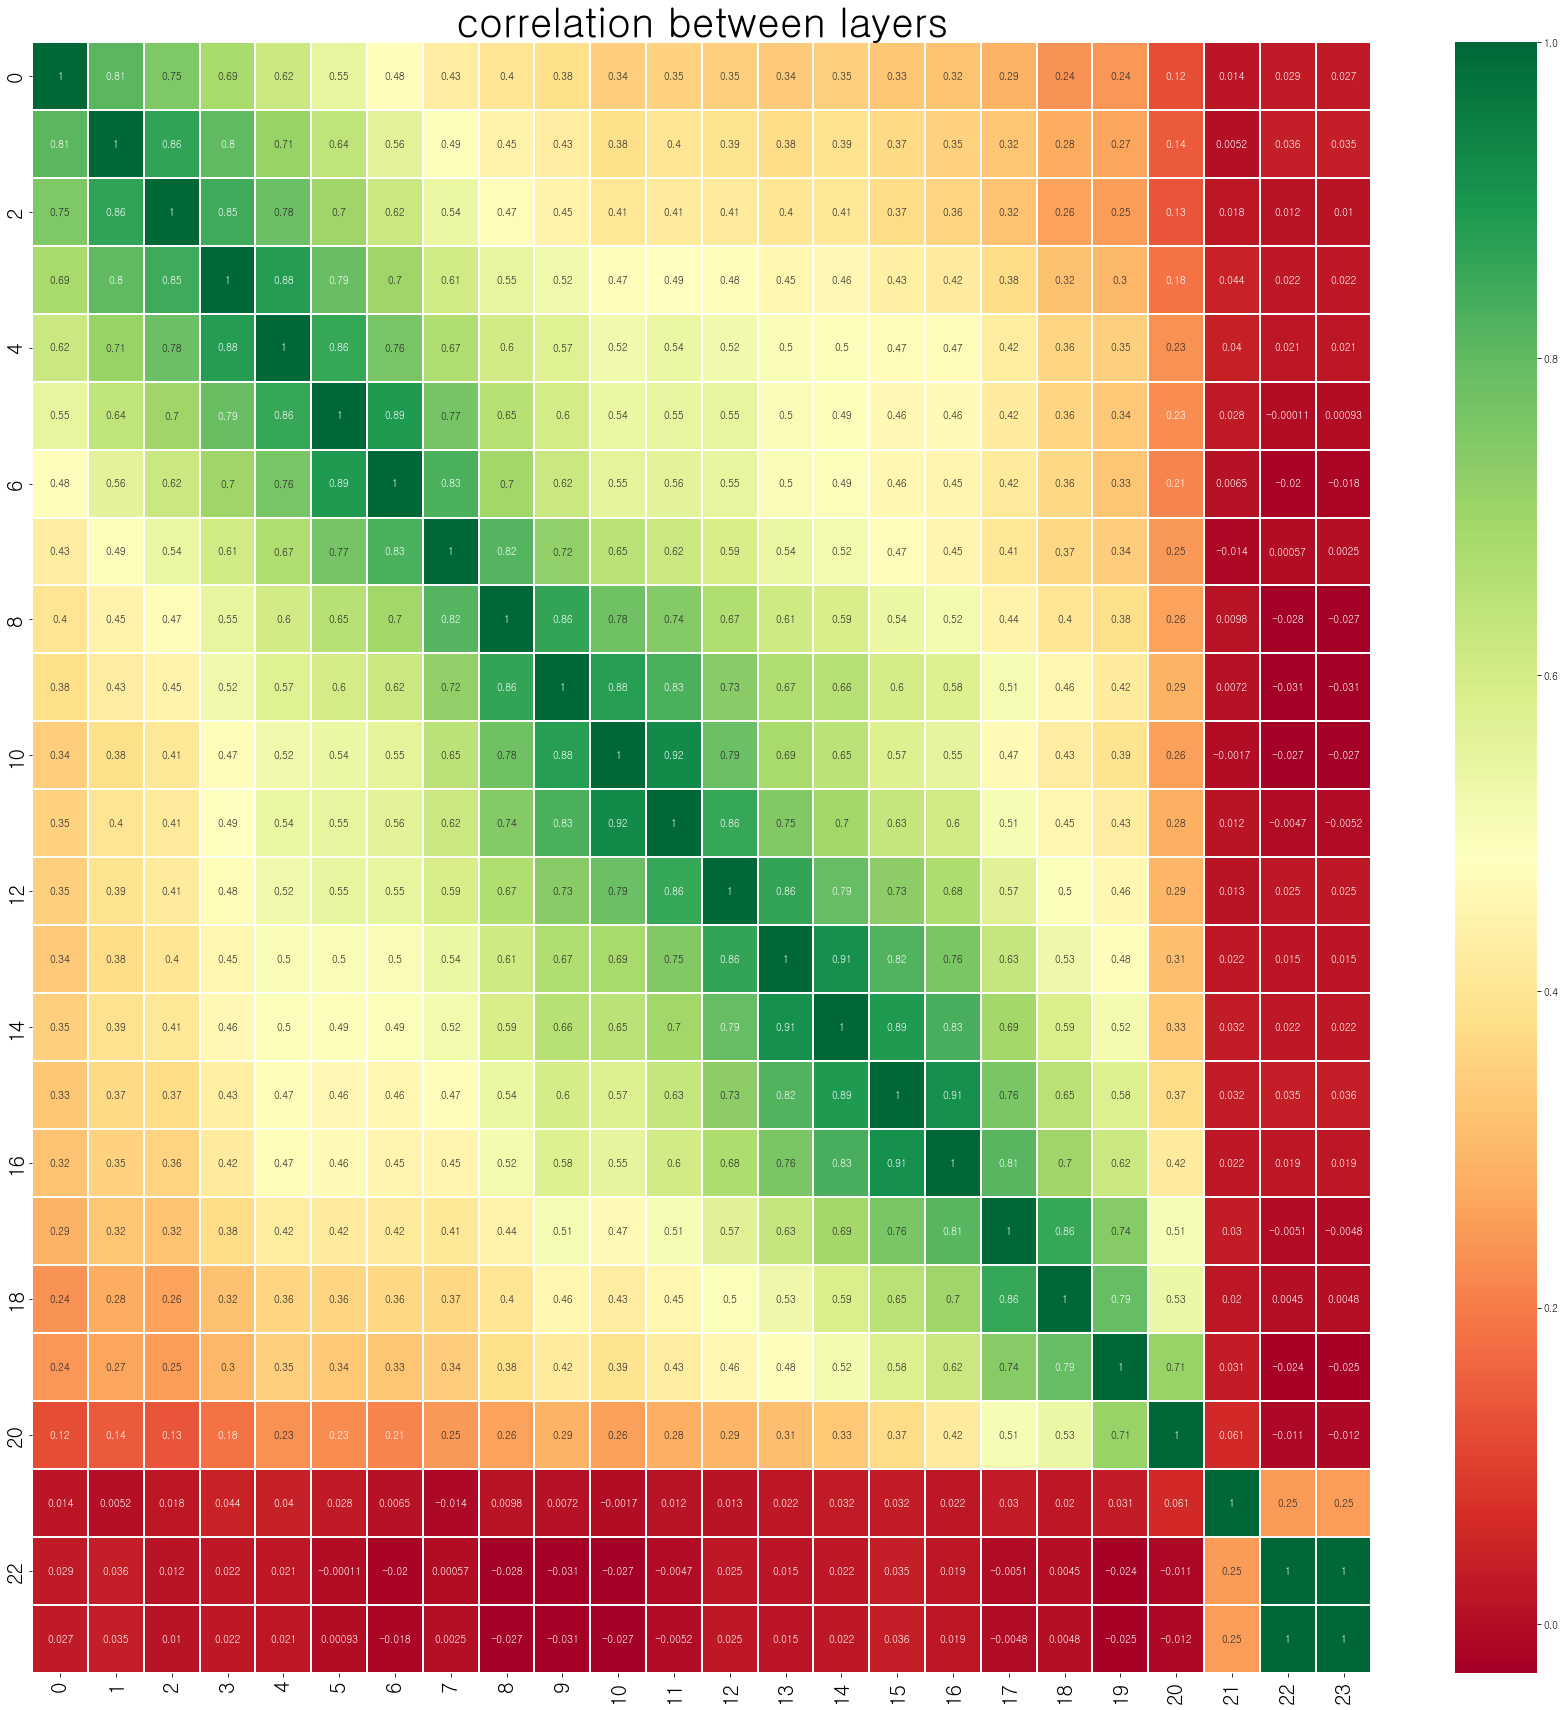

In [137]:
heatmap = sns.heatmap(x_pd[0].corr(),annot = True, cmap='RdYlGn',linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(30,30)
heatmap.set_xticklabels(heatmap.get_xticklabels(),fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)

plt.title('correlation between layers', fontsize=40)
plt.show()


-1.071021e-08
9.313226e-09
-3.259629e-09
2.3283064e-09
-1.7229468e-08
-2.0489097e-08
8.381903e-09
-1.8626451e-09
-1.3504177e-08
2.0954758e-08
1.5832484e-08
-7.450581e-09
-1.0244548e-08
5.5879354e-09
-6.0535967e-09
-1.3038516e-08
-9.313226e-09
-3.306195e-08
9.313226e-09
1.7229468e-08
2.6077032e-08
-9.313226e-10
-1.3969839e-09
-9.778887e-09
1.1175871e-08
-1.2572855e-08
-9.313226e-10
-7.450581e-09
1.3969839e-08
4.656613e-09
1.3038516e-08
1.5366822e-08


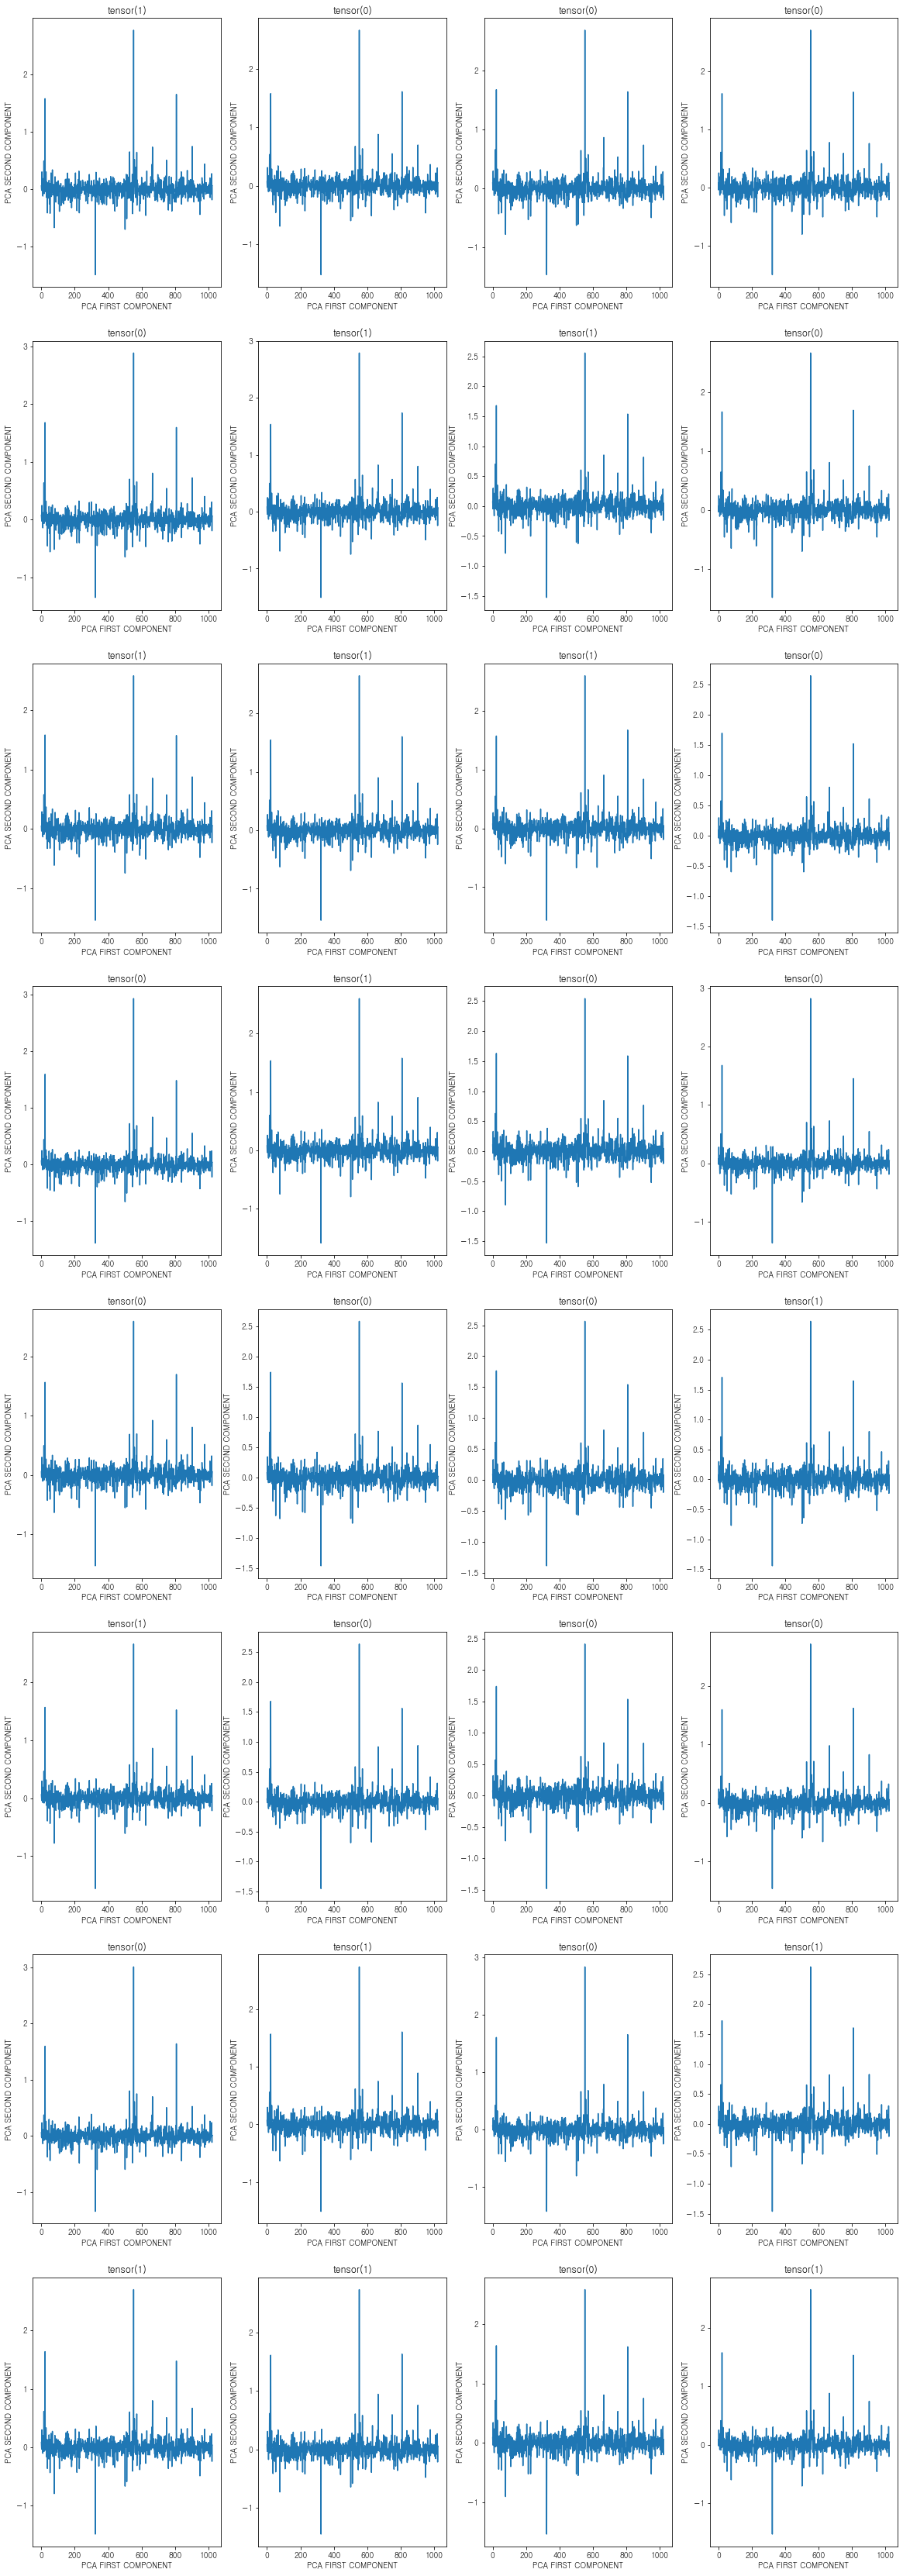

In [161]:
# PCA 구현
# 1. 2D SPACE 축소
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

pca_list= []

plt.figure(figsize=(20,60))
for i in range(32):
    
    scaler = MinMaxScaler()
    DATA_norm = scaler.fit_transform(x_pd[i])
    DATA_norm = pd.DataFrame(DATA_norm)    
    
    pca2=PCA(n_components=2)
    pca2.fit(DATA_norm)
    pca2_data=pca2.transform(DATA_norm)
    pca2_df=pd.DataFrame(pca2_data,columns=['PCA1','PCA2'])
    pca_list.append(pca2_df)
    plt.subplot(8,4,i+1)

    plt.plot(range(1024),pca2_df.iloc[:,0])
    

    plt.xlabel('PCA FIRST COMPONENT')
    plt.ylabel('PCA SECOND COMPONENT')
    plt.title(label[i])
    print(pca2_df.iloc[:,0].mean())
plt.show()

In [ ]:
# PCA 구현
# 1. 2D SPACE 축소
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


plt.figure(figsize=(20,60))
for i in range(32):
    
    #pca2=PCA(n_components=2)
    #pca2.fit(x_pd[i])
    #pca2_data=pca2.transform(x_pd[i])
    pca2_df=pd.DataFrame(pca2_data,columns=['PCA1','PCA2'])
    plt.subplot(8,4,i+1)

    plt.plot(pca2_df.iloc[:,0],pca2_df.iloc[:,1],label='')


    plt.xlabel('PCA FIRST COMPONENT')
    plt.ylabel('PCA SECOND COMPONENT')
    plt.title(label[i])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


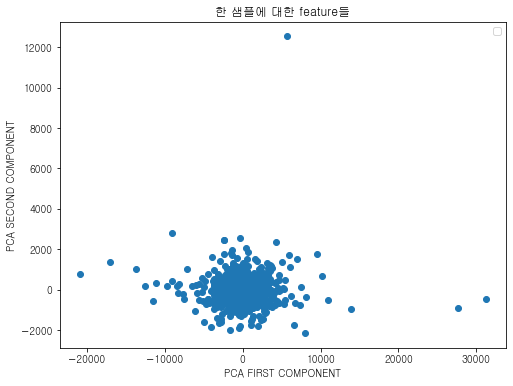

In [96]:
# PCA 구현
# 1. 2D SPACE 축소
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


pca2=PCA(n_components=2)
pca2.fit(x_pd)
pca2_data=pca2.transform(x_pd)
pca2_df=pd.DataFrame(pca2_data,columns=['PCA1','PCA2'])


fig =plt.figure(figsize=(8,6))


plt.scatter(pca2_df.iloc[:,0],pca2_df.iloc[:,1],label='')


plt.xlabel('PCA FIRST COMPONENT')
plt.ylabel('PCA SECOND COMPONENT')
plt.title("한 샘플에 대한 feature들")
plt.show()

In [150]:
pca2_df

,PCA1,PCA2
0,617.880615,531.249695
1,881.843811,-322.433563
2,1091.399780,1672.605713
3,-1141.015503,-693.616943
4,4411.652832,2.595966
...,...,...
1019,-3195.055176,-467.903015
1020,304.531891,-2.504639
1021,2403.215332,532.644897
1022,212.541016,-151.729004


In [169]:
pca_list[6]

,PCA1,PCA2
0,0.069701,0.079632
1,-0.002647,-0.028232
2,-0.046494,0.002332
3,0.299137,0.028039
4,-0.039745,-0.000989
...,...,...
1019,0.284457,-0.114956
1020,-0.049536,0.019108
1021,-0.236971,0.100278
1022,0.011373,-0.054221


# 모델 결과값 확인

In [13]:
#https://pytorch.org/audio/0.9.0/models.html#baevski2020wav2vec
from torchaudio.models.wav2vec2.utils import import_huggingface_model
from transformers import Wav2Vec2ForCTC

In [14]:
for x_train,label,sig_size in train_loader:
    print(label,sig_size)
    break

tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 1]) tensor([43140, 27549, 32207, 34470, 33266, 31850, 52908, 25514, 48533, 36183,
        30303, 22471, 25063, 39343, 28791, 40774, 35879, 55166, 27714, 27430,
        29662, 31766, 40710, 46009, 31483, 32938, 23724, 27750, 27084, 42471,
        49687, 31600])


In [16]:
#hugging face에서 pretraiend 된 모댈을 다운받아서
original = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-lv60")
model = import_huggingface_model(original)
torch.save(model.state_dict(), "../checkpoint/wav2vec2-large-lv60.pt")




Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-large-lv60 were not used when initializing Wav2Vec2ForCTC: ['project_q.bias', 'quantizer.weight_proj.weight', 'quantizer.weight_proj.bias', 'project_q.weight', 'quantizer.codevectors', 'project_hid.bias', 'project_hid.weight']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-lv60 and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it 

In [15]:
model = torchaudio.models.wav2vec2_large_lv60k(aux_num_out=32).to(DEVICE)
model.load_state_dict(torch.load("../checkpoint/wav2vec2-large-lv60.pt"))

<All keys matched successfully>

In [18]:
model

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
      )
      (1): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (2): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (3): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (4): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (5): ConvLayerBlock(
        (lay

In [16]:
model.aux = nn.Linear(1024,2,bias=True).to(DEVICE)

In [20]:
model

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
      )
      (1): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (2): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (3): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (4): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (5): ConvLayerBlock(
        (lay

In [17]:
with torch.inference_mode():
    x_train=x_train.to(DEVICE)
    sig_size = sig_size.to(DEVICE)
    x1,x1_len = model.extract_features(x_train,sig_size)
    x2,out_len = model(x_train.to(DEVICE),sig_size)
    x3,_ = model.feature_extractor(x_train,sig_size) #encoder의 이미지

In [55]:
print(len(x1),x1[0].size(),'/',x2.size(),x3.size())

24 torch.Size([32, 318, 1024]) / torch.Size([32, 318, 2]) torch.Size([32, 318, 512])


In [38]:
x3[0].size()

torch.Size([32, 318, 512])

In [18]:
out_len

tensor([134,  85, 100, 107, 103,  99, 165,  79, 151, 112,  94,  69,  78, 122,
         89, 127, 111, 172,  86,  85,  92,  99, 126, 143,  98, 102,  73,  86,
         84, 132, 155,  98], device='cuda:0')

In [25]:
zero_padding_array=torch.ones((32,318,2))
zero_padding_array[0,134:,:]=0

In [38]:

zero_padding_array=np.ones((32,318,2))
for i in range(len(out_len)):
    zero_padding_array[i:,out_len[i]:,:]=0

In [43]:
x2=x2*torch.from_numpy(zero_padding_array).to(DEVICE)

In [44]:
x2.size()

torch.Size([32, 318, 2])

In [21]:
x2[0,134:,:]

RuntimeError: Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.

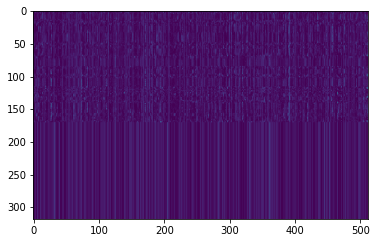

In [57]:
plt.imshow(x3[0].cpu().detach().numpy() )
#raw data feature
#invalid한 프레임이 눈에 띈다.
#150 이하로는 사용할 필요가 없다.

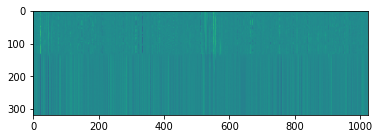

In [66]:
plt.imshow(x1[0][3].cpu())
#이건 encoder feature
#마찬가지로 150 이후로는 사용할 필요가 없다.

In [63]:
x1[0][3].cpu().mean(axis=1).size()

torch.Size([318])

In [84]:
x2.size()# 이걸로 학습 시키자!!!!
#근데 이거 pretrained 됬을거다.

#이걸로 finetuning 시키고


torch.Size([32, 318, 2])

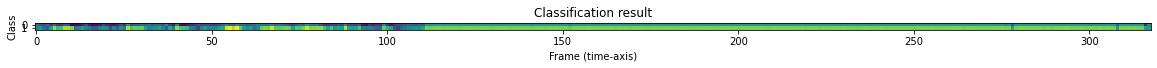

In [111]:
plt.figure(figsize=(20,20))

plt.imshow(x2[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)") #주의할점은. padding을 잘 처리해줘야하는 것.
plt.ylabel("Class")
plt.show()


In [58]:
??torchaudio.models.wav2vec2_large_lv60k

In [52]:
for x_train,label in train_loader:
    print(label)
    break

bundle = torchaudio.pipelines.WAV2VEC2_LARGE_LV60K
model_wav2vec = bundle.get_model().to(DEVICE)
with torch.inference_mode():
    x1,_ = model_wav2vec.extract_features(x_train.cuda())
    x2,_ = model_wav2vec(x_train.cuda())
    


tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 0])


In [54]:
model_wav2vec

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
      )
      (1): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (2): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (3): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (4): ConvLayerBlock(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
      )
      (5): ConvLayerBlock(
        (lay

In [39]:
x1[23].size()

torch.Size([32, 318, 1024])

In [40]:
x2.size()

torch.Size([32, 318, 1024])

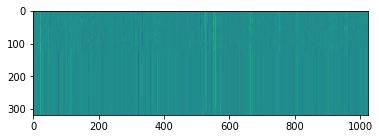

In [41]:
plt.imshow(x1[0][23].cpu())

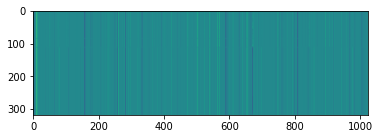

In [44]:
plt.imshow(x2[0].cpu())

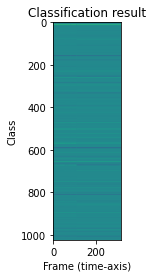

AttributeError: 'Wav2Vec2Bundle' object has no attribute 'get_labels'

In [45]:
plt.imshow(x2[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

16000

----

In [15]:
###
sr=16000
win_length =  np.int64(sr/40) #
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


        
class wav_path_Net(nn.Module):
    def __init__(self,):
        super(wav_path_Net,self).__init__()
        
        bundle = torchaudio.pipelines.WAV2VEC2_LARGE_LV60K
        self.model_wav2vec = bundle.get_model().to(DEVICE)
        
        
        input_dim =101951
        
        self.fc = nn.Sequential(nn.Linear(24*1024,1024),
                                nn.BatchNorm1d(1024),
                                nn.ReLU(),
                                nn.Dropout(p=0.7),
                                nn.Linear(1024,256),
                                nn.BatchNorm1d(256),
                                nn.ReLU(),
                                nn.Dropout(p=0.7),
                                nn.Linear(256,2),)
        
        
    def merge(self,hidden_feature):
        hidden_feature=[ feat.mean(axis=1) for feat  in  hidden_feature]
        return hidden_feature
        
        
    def forward(self,x):
        with torch.inference_mode():
            x,_ = self.model_wav2vec.extract_features(x)
        x = self.merge(x)
        x = torch.stack(x,dim=1)
        x = x.view(-1,24*1024)
        x= self.fc(x)
    
        return x 
    


In [16]:
###
sr=16000
win_length =  np.int64(sr/40) #
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



        
class wav_path_Net(nn.Module):
    def __init__(self,):
        super(wav_path_Net,self).__init__()
        
        bundle = torchaudio.pipelines.WAV2VEC2_LARGE_LV60K
        self.model_wav2vec = bundle.get_model().to(DEVICE)
        
        
        #input_dim =101951
        
        self.fc = nn.Sequential(
                                nn.Linear(1024,256),
                                nn.BatchNorm1d(256),
                                nn.ReLU(),
                                nn.Dropout(p=0.7),
                                nn.Linear(256,2),)
        
        
    def merge(self,hidden_feature):
        hidden_feature=hidden_feature.mean(axis=1)
        return hidden_feature
        
        
    def forward(self,x):
        with torch.inference_mode():
            x,_ = self.model_wav2vec.extract_features(x)
        x = x[3]
        x = self.merge(x)
        #x = torch.stack(x,dim=1)
        #x = x.view(-1,1024)
        x= self.fc(x)
    
        return x 
    


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
###
sr=16000
win_length =  np.int64(sr/40) #
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model_wav2vec = bundle.get_model().to(DEVICE)

print(model_wav2vec.__class__)

        
class wav_path_Net(nn.Module):
    def __init__(self,):
        super(wav_path_Net,self).__init__()
        
        bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
        self.model_wav2vec = bundle.get_model().to(DEVICE)
        self.res_18 = models.resnet18(pretrained=True)
        self.conv_model1=nn.Conv2d(12,3,(3,3))
        
        #input_dim =101951
        
        self.fc = nn.Sequential(nn.Linear(1000,512),
                                nn.BatchNorm1d(512),
                                nn.ReLU(),
                                nn.Linear(512,256),
                                nn.BatchNorm1d(256),
                                nn.ReLU(),
                                nn.Linear(256,50),
                                nn.Linear(50,2),)
        
        
    def merge(self,hidden_feature):
        hidden_feature=[ feat.mean(axis=1) for feat  in  hidden_feature]
        return hidden_feature
        
        
    def forward(self,x):
        with torch.inference_mode():
            x,_ = self.model_wav2vec.extract_features(x)
        x = torch.stack(x,axis=1)
        x = self.conv_model1(x)
        x = self.res_18(x)
        x= self.fc(x)
    
        return x 
    


In [16]:
#7. Optimizer, Objective Function
def model_initialize():
    model = wav_path_Net().to(DEVICE)
    #원핫 인코딩값의 loss는 crossEntropyLoss로 비교
    #print(model)
    return model

In [17]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [18]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [19]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    return train_loader,validation_loader



In [19]:
#10. 학습 및 평가.
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = '../checkpoint/checkpoint_w2v_'+str(data_ind)+'.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

../checkpoint/checkpoint_w2v_1.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0217	 Train Acc:60.88 %  | 	Valid Loss:0.0704 	Valid Acc: 34.81 %

Validation loss decreased (inf --> 0.070430).  Saving model ...

[EPOCH:2]	 Train Loss:0.0200	 Train Acc:66.19 %  | 	Valid Loss:0.0179 	Valid Acc: 72.70 %

Validation loss decreased (0.070430 --> 0.017878).  Saving model ...

[EPOCH:3]	 Train Loss:0.0193	 Train Acc:69.00 %  | 	Valid Loss:0.0374 	Valid Acc: 46.42 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0183	 Train Acc:71.56 %  | 	Valid Loss:0.0742 	Valid Acc: 36.86 %

EarlyStopping counter: 2 out of 5

[EPOCH:5]	 Train Loss:0.0176	 Train Acc:71.56 %  | 	Valid Loss:0.0165 	Valid Acc: 77.82 %

Validation loss decreased (0.017878 --> 0.016472).  Saving model ...

[EPOCH:6]	 Train Loss:0.0170	 Train Acc:74.38 %  | 	Valid Loss:0.0244 	Valid Acc: 57.68 %

EarlyStopping counter: 1 out of 5

[EPOCH:7]	 Train Loss:0.0161	 Train Acc:75.88 %  | 	Valid Loss:0.0212 	Valid Acc: 65.1


[EPOCH:26]	 Train Loss:0.0134	 Train Acc:79.36 %  | 	Valid Loss:0.0140 	Valid Acc: 83.22 %

Validation loss decreased (0.014457 --> 0.013967).  Saving model ...

[EPOCH:27]	 Train Loss:0.0137	 Train Acc:80.08 %  | 	Valid Loss:0.0169 	Valid Acc: 69.86 %

EarlyStopping counter: 1 out of 5

[EPOCH:28]	 Train Loss:0.0133	 Train Acc:81.39 %  | 	Valid Loss:0.0174 	Valid Acc: 71.92 %

EarlyStopping counter: 2 out of 5

[EPOCH:29]	 Train Loss:0.0127	 Train Acc:82.11 %  | 	Valid Loss:0.0248 	Valid Acc: 68.49 %

EarlyStopping counter: 3 out of 5

[EPOCH:30]	 Train Loss:0.0127	 Train Acc:81.19 %  | 	Valid Loss:0.0375 	Valid Acc: 65.41 %

EarlyStopping counter: 4 out of 5

[EPOCH:31]	 Train Loss:0.0126	 Train Acc:81.39 %  | 	Valid Loss:0.0286 	Valid Acc: 65.75 %

EarlyStopping counter: 5 out of 5
[4 교차검증] Early stopping
../checkpoint/checkpoint_w2v_5.pt
[5 교차검증] 학습 시작
 ----- 


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\USER\AppData\Local\Temp/ipykernel_8020/534950350.py", line 24, in <module>
    train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
  File "C:\Users\USER\AppData\Local\Temp/ipykernel_8020/1868480107.py", line 11, in train
    output = model(image) # model로 output을 계산
  File "C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\nn\modules\module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "C:\Users\USER\AppData\Local\Temp/ipykernel_8020/337288327.py", line 43, in forward
    x= self.fc(x)
  File "C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\nn\modules\module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "C:\Users\USER\anaconda3\envs\loca

TypeError: object of type 'NoneType' has no len()

In [ ]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

In [ ]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def test_evaluate(model,test_loader):
    model.eval()
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            output = F.softmax(output, dim=1).data.squeeze() # softmax 적용 (모델을 통과는 했지만, criterion는 안통과함.)
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
        return predictions,answers

In [ ]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = '../checkpoint/checkpoint_w2v_'+str(data_ind)+'.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))


